### Code for Implementing the Policy Gradient Method to the Cart Pole Reinforcement Learning Problem

Hilda Ibriga

#### Note: Please read before proceeding
This code was implemented using the latest version of python at the time which was python 3.7.1. The user will need to create a Tensorflow session. 
I was able to implement this code by reading several tutorials on Github on Reinforcement learning algorithm implementation and tensorflow user guides.

#### Loading the necessary tensor flow and plotting packages

In [1]:
from __future__ import print_function
import numpy as np
import pickle as pickle
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import math

#### Loading the carte-pole environment from the OpenAI gym gihub repository

Instructions on how to use the cart-pole environment can be found [here](https://gym.openai.com/envs/CartPole-v0/)

In [2]:
import gym
env = gym.make('CartPole-v0')

### Setting the Neural Network constant hyperparameters

In [3]:
H = 32 # number of hidden layer neurons
learning_rate = 1e-2
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?

model_bs = 6 # Batch size when learning from model
real_bs = 6 # Batch size when learning from real environment

# model initialization
D = 4 # input dimensionality

#### Building the Neural Network  graph architecture for learning the Optimal Policy

In [4]:
tf.reset_default_graph()
observations = tf.placeholder(tf.float32, [None,4] , name="input_x") # place holder for the input layer
W1 = tf.get_variable("W1", shape=[4, H],
           initializer=tf.contrib.layers.xavier_initializer()) # weight w1 initialized
layer1 = tf.nn.relu(tf.matmul(observations,W1))
W2 = tf.get_variable("W2", shape=[H, 1],
           initializer=tf.contrib.layers.xavier_initializer()) # weight W2 initialized
score = tf.matmul(layer1,W2)
probability = tf.nn.sigmoid(score)  # using the sigmoid function to convert output of the hiden layer to probability

tvars = tf.trainable_variables()
input_y = tf.placeholder(tf.float32,[None,1], name="input_y")
advantages = tf.placeholder(tf.float32,name="reward_signal")
adam = tf.train.AdamOptimizer(learning_rate=learning_rate)
W1Grad = tf.placeholder(tf.float32,name="batch_grad1")
W2Grad = tf.placeholder(tf.float32,name="batch_grad2")
batchGrad = [W1Grad,W2Grad]
loglik = tf.log(input_y*(input_y - probability) + (1 - input_y)*(input_y + probability)) # using the cross entropy for the log likelihood function
loss = -tf.reduce_mean(loglik * advantages)  # loss function based on cross entropy
newGrads = tf.gradients(loss,tvars)
updateGrads = adam.apply_gradients(zip(batchGrad,tvars))

#### Building the Neural Network graph architecture for learning a model of the Environement

In [5]:
mH = 250 # number of nodes in the single hidden layer of the neural network

input_data = tf.placeholder(tf.float32, [None, 5])   # place holder for input tensor
with tf.variable_scope('rnnlm'):
    softmax_w = tf.get_variable("softmax_w", [mH, 50])
    softmax_b = tf.get_variable("softmax_b", [50])

previous_state = tf.placeholder(tf.float32, [None,5] , name="previous_state") # place holder for the previous state of the environment
W1M = tf.get_variable("W1M", shape=[5, mH],
           initializer=tf.contrib.layers.xavier_initializer()) # first set of weights inialization
B1M = tf.Variable(tf.zeros([mH]),name="B1M")                  # initializing the bias term for the first set of weights
layer1M = tf.nn.relu(tf.matmul(previous_state,W1M) + B1M)
W2M = tf.get_variable("W2M", shape=[mH, mH],               
           initializer=tf.contrib.layers.xavier_initializer())   # Second set of weights inialization
B2M = tf.Variable(tf.zeros([mH]),name="B2M")
layer2M = tf.nn.relu(tf.matmul(layer1M,W2M) + B2M)                # initializing the bias term for the second set of weights
wO = tf.get_variable("wO", shape=[mH, 4],
           initializer=tf.contrib.layers.xavier_initializer()) # weight for state prediction output
wR = tf.get_variable("wR", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer()) # weight for reward prediction output
wD = tf.get_variable("wD", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer()) # weight for pole fall status prediction output

bO = tf.Variable(tf.zeros([4]),name="bO") # bias for state prediction
bR = tf.Variable(tf.zeros([1]),name="bR") # bias for reward prediction
bD = tf.Variable(tf.ones([1]),name="bD") # bias for pole fall status prediction


predicted_observation = tf.matmul(layer2M,wO,name="predicted_observation") + bO # predicted value state
predicted_reward = tf.matmul(layer2M,wR,name="predicted_reward") + bR           # predicted value reward
predicted_done = tf.sigmoid(tf.matmul(layer2M,wD,name="predicted_done") + bD)  # predicted value fall status

true_observation = tf.placeholder(tf.float32,[None,4],name="true_observation")  # true obsevation state
true_reward = tf.placeholder(tf.float32,[None,1],name="true_reward")   # true observation reward
true_done = tf.placeholder(tf.float32,[None,1],name="true_done")  # true obsevration fall status


predicted_state = tf.concat([predicted_observation,predicted_reward,predicted_done],1) # combining state reward and status into one vector

observation_loss = tf.square(true_observation - predicted_observation) # computing the loss function for state: measn square loss

reward_loss = tf.square(true_reward - predicted_reward) # loss function for reward means square loss

done_loss = tf.multiply(predicted_done, true_done) + tf.multiply(1-predicted_done, 1-true_done) # loss function of status cross entropy
done_loss = -tf.log(done_loss)

model_loss = tf.reduce_mean(observation_loss + done_loss + reward_loss) # obtaining the model loss function by summing all three types of loss functions

modelAdam = tf.train.AdamOptimizer(learning_rate=learning_rate) # using the adam optimizer to perfom gradient descent
updateModel = modelAdam.minimize(model_loss) # updating the gradients and weights

#### Two helper functions to generate the next environment state and compute the discounted cumulative reward at each time point

In [6]:
def resetGradBuffer(gradBuffer):
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
    return gradBuffer
        
def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r


#  produces a new state when given a previous state and action using the learn model from the neural network
def stepModel(sess, xs, action):
    toFeed = np.reshape(np.hstack([xs[-1][0],np.array(action)]),[1,5])
    myPredict = sess.run([predicted_state],feed_dict={previous_state: toFeed})
    reward = myPredict[0][:,4]
    observation = myPredict[0][:,0:4]
    observation[:,0] = np.clip(observation[:,0],-2.4,2.4)
    observation[:,2] = np.clip(observation[:,2],-0.4,0.4)
    doneP = np.clip(myPredict[0][:,5],0,1)
    if doneP > 0.1 or len(xs)>= 300:
        done = True
    else:
        done = False
    return observation, reward, done

#### Implementing the two algorithms: policy gradient and learning the model of the environment alternatively

In [7]:
xs,drs,ys,ds = [],[],[],[]
reward_All=[]
running_reward = None
reward_sum = 0
episode_number = 1
real_episodes = 1
init = tf.global_variables_initializer()
batch_size = real_bs

drawFromModel = False # When set to True, will use model for observations
trainTheModel = True # Whether to train the model
trainThePolicy = False # Whether to train the policy
switch_point = 1

# Launch the graph
with tf.Session() as sess:
    rendering = False
    sess.run(init)
    observation = env.reset()
    x = observation
    gradBuffer = sess.run(tvars)
    gradBuffer = resetGradBuffer(gradBuffer)
    
    while episode_number <= 2200:
        # Start displaying environment once performance is acceptably high.
        if (reward_sum/batch_size > 5 and drawFromModel == False) or rendering == True : 
            env.render()
            rendering = True
            
        x = np.reshape(observation,[1,4])

        tfprob = sess.run(probability,feed_dict={observations: x})
        action = 1 if np.random.uniform() < tfprob else 0

        # record various intermediates (needed later for backprop)
        xs.append(x) 
        y = 1 if action == 0 else 0 
        ys.append(y)
        
        # step the  model or real environment and get new measurements
        if drawFromModel == False:
            observation, reward, done, info = env.step(action)
        else:
            observation, reward, done = stepModel(sess,xs,action)
                
        reward_sum += reward
        
        ds.append(done*1)
        drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

        if done: 
            
            if drawFromModel == False: 
                real_episodes += 1
            episode_number += 1

            # stack together all inputs, hidden states, action gradients, and rewards for this episode
            epx = np.vstack(xs)
            epy = np.vstack(ys)
            epr = np.vstack(drs)
            epd = np.vstack(ds)
            xs,drs,ys,ds = [],[],[],[] # reset array memory
            
            if trainTheModel == True:
                actions = np.array([np.abs(y-1) for y in epy][:-1])
                state_prevs = epx[:-1,:]
                state_prevs = np.hstack([state_prevs,actions])
                state_nexts = epx[1:,:]
                rewards = np.array(epr[1:,:])
                dones = np.array(epd[1:,:])
                state_nextsAll = np.hstack([state_nexts,rewards,dones])

                feed_dict={previous_state: state_prevs, true_observation: state_nexts,true_done:dones,true_reward:rewards}
                loss,pState,_ = sess.run([model_loss,predicted_state,updateModel],feed_dict)
            if trainThePolicy == True:
                discounted_epr = discount_rewards(epr).astype('float32')
                discounted_epr -= np.mean(discounted_epr)
                discounted_epr /= np.std(discounted_epr)
                tGrad = sess.run(newGrads,feed_dict={observations: epx, input_y: epy, advantages: discounted_epr})
                
                # If gradients becom too large, end training process
                if np.sum(tGrad[0] == tGrad[0]) == 0:
                    break
                for ix,grad in enumerate(tGrad):
                    gradBuffer[ix] += grad
                
            if switch_point + batch_size == episode_number: 
                switch_point = episode_number
                if trainThePolicy == True:
                    sess.run(updateGrads,feed_dict={W1Grad: gradBuffer[0],W2Grad:gradBuffer[1]})
                    gradBuffer = resetGradBuffer(gradBuffer)

                running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
                if drawFromModel == False:
                    print('Model based Episode %f. Reward %f. action: %f. mean reward %f.' % (real_episodes,reward_sum/real_bs,action, running_reward/real_bs))
                    reward_All.append([real_episodes,reward_sum/real_bs,action, running_reward/real_bs])
                    if reward_sum/batch_size > 200:
                        break
                reward_sum = 0

                # Once the model has been trained on 100 episodes, we start alternating between training the policy
                # from the model and training the model from the real environment.
                if episode_number > 100:
                    drawFromModel = not drawFromModel
                    trainTheModel = not trainTheModel
                    trainThePolicy = not trainThePolicy
            
            if drawFromModel == True:
                observation = np.random.uniform(-0.1,0.1,[4]) # Generate reasonable starting point
                batch_size = model_bs
            else:
                observation = env.reset()
                batch_size = real_bs
                
print(real_episodes)

Model based Episode 7.000000. Reward 34.000000. action: 0.000000. mean reward 34.000000.
Model based Episode 13.000000. Reward 25.333333. action: 1.000000. mean reward 33.913333.
Model based Episode 19.000000. Reward 19.833333. action: 0.000000. mean reward 33.772533.
Model based Episode 25.000000. Reward 18.333333. action: 1.000000. mean reward 33.618141.
Model based Episode 31.000000. Reward 21.833333. action: 1.000000. mean reward 33.500293.
Model based Episode 37.000000. Reward 29.166667. action: 0.000000. mean reward 33.456957.
Model based Episode 43.000000. Reward 15.166667. action: 0.000000. mean reward 33.274054.
Model based Episode 49.000000. Reward 20.833333. action: 0.000000. mean reward 33.149647.
Model based Episode 55.000000. Reward 26.333333. action: 1.000000. mean reward 33.081484.
Model based Episode 61.000000. Reward 25.833333. action: 0.000000. mean reward 33.009002.
Model based Episode 67.000000. Reward 25.666667. action: 0.000000. mean reward 32.935579.
Model based

Model based Episode 553.000000. Reward 96.666667. action: 1.000000. mean reward 63.240482.
Model based Episode 559.000000. Reward 89.666667. action: 1.000000. mean reward 63.223572.
Model based Episode 565.000000. Reward 80.000000. action: 1.000000. mean reward 64.373650.
Model based Episode 571.000000. Reward 98.833333. action: 1.000000. mean reward 64.226860.
Model based Episode 577.000000. Reward 79.333333. action: 1.000000. mean reward 64.304573.
Model based Episode 583.000000. Reward 85.666667. action: 1.000000. mean reward 64.171181.
Model based Episode 589.000000. Reward 91.333333. action: 1.000000. mean reward 63.989666.
Model based Episode 595.000000. Reward 95.833333. action: 0.000000. mean reward 65.960762.
Model based Episode 601.000000. Reward 71.333333. action: 1.000000. mean reward 65.874016.
Model based Episode 607.000000. Reward 90.333333. action: 0.000000. mean reward 66.062210.
Model based Episode 613.000000. Reward 126.666667. action: 1.000000. mean reward 66.229317

Model based Episode 1087.000000. Reward 200.000000. action: 1.000000. mean reward 145.561707.
Model based Episode 1093.000000. Reward 193.166667. action: 1.000000. mean reward 145.489105.
Model based Episode 1099.000000. Reward 189.833333. action: 0.000000. mean reward 147.509216.
Model based Episode 1105.000000. Reward 192.166667. action: 0.000000. mean reward 147.042633.
Model based Episode 1111.000000. Reward 189.166667. action: 0.000000. mean reward 149.267395.
Model based Episode 1117.000000. Reward 200.000000. action: 1.000000. mean reward 148.821396.
Model based Episode 1123.000000. Reward 200.000000. action: 0.000000. mean reward 150.766312.
Model based Episode 1129.000000. Reward 200.000000. action: 1.000000. mean reward 151.923264.
Model based Episode 1135.000000. Reward 200.000000. action: 1.000000. mean reward 152.489944.
Model based Episode 1141.000000. Reward 200.000000. action: 0.000000. mean reward 154.454361.
Model based Episode 1147.000000. Reward 200.000000. action: 

#### Plotting the predicted model of the environement obtained fromt the neural network

C:\Users\somnooma\Anaconda3\envs\TensorflowSessions\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


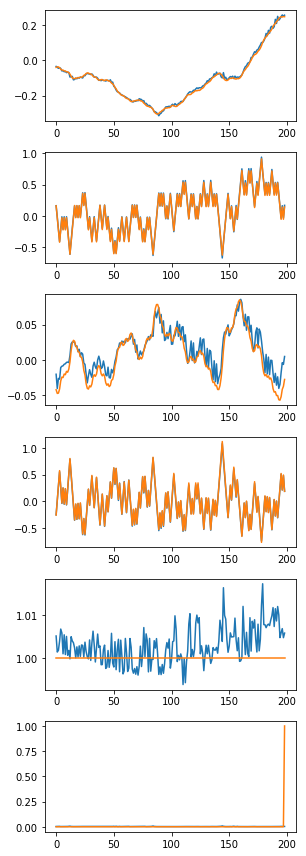

In [8]:
plt.figure(figsize=(8, 12))
for i in range(6):
    plt.subplot(6, 2, 2*i + 1)
    plt.plot(pState[:,i])
    plt.subplot(6,2,2*i+1)
    plt.plot(state_nextsAll[:,i])
plt.tight_layout()

#### Ploting the performance of the algorithm : reward and smoothed reward

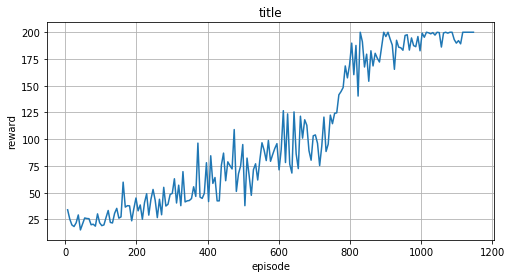

In [19]:
import pandas as pd
df = pd.DataFrame(reward_All)

plt.plot(df[0], df[1])
plt.rcParams["figure.figsize"] = [8,8]
plt.title("title")
plt.xlabel("episode")
plt.ylabel("reward")
plt.grid()
plt.show()


In [ ]:
plt.plot(df[0], df[3])
plt.rcParams["figure.figsize"] = [8,8]
plt.title("title")
plt.xlabel("episode")
plt.ylabel("reward_smooth10")
plt.grid()
plt.show()